Paper Trading
* [Alpaca](https://app.alpaca.markets/signup)
* [QuantConnect](https://www.quantconnect.com)

# Import Libraries

In [1]:
# Web Scraping
from bs4 import BeautifulSoup
from lxml import html
import requests


# NLP
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from contractions import CONTRACTION_MAP
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
from nltk.tokenize import MWETokenizer # multi-word expression
from nltk.tag import pos_tag
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

from gensim import corpora, models, similarities, matutils
import spacy
#python -m spacy download en_core_web_md
import en_core_web_md
import langdetect
nlp = en_core_web_md.load(parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
#nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list+=['crypto','Crypto' 'cryptocurrencie', 'cryptocurrencies', 'Cryptocurrencies', 
                'cryptocurrency','Cryptocurrency', 'btc','Bitcoin','bitcoin','cryptocryptocurrencie']

# stopword_list.remove('no')
# stopword_list.remove('not')
from sklearn.decomposition import NMF
from spacy import displacy
#!pip install vaderSentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Tools
import string
from datetime import date,timedelta,datetime
import unicodedata
import time
import re
import os
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm, trange
from sklearn import preprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
#pd.reset_option('^display.', silent=True) #Resets all pandas options

# Modeling
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Functions

#### Helper Functions

In [249]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


# example) do not -> don't. I would -> I'd
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# standardized into ASCII characters. example) converting é to e
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text 

# Special characters and symbols
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
#         # remove stopwords
#         if stopword_removal:
#             doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Scraping

#### Google News Scraping Function

In [541]:
# Load webpage's url and load it into soup
def load_soup(url):
    user_agent_list = [
       #Chrome
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
         ]
    

    
    headers = {"User-Agent":random.choice(user_agent_list)}
    response = requests.get(url,headers=headers)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup,response.status_code

def scrape_bitcoin_news_google(num_per_page=40):

    # Define start and end dates
    with open('pickles/df_news_processed.pkl', 'rb') as picklefile: 
        df_news_processed = pickle.load(picklefile) 
    start_date = max(df_news_processed['date'])+timedelta(days=1)
    end_date = date.today()
    
    # Create "pickles" folder if it's not there
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
    if 'pickles' not in os.listdir(git_folder_location):
        !mkdir 'pickles'

    # already scraped (list from what's already saved in the folder)
    done_list = list(df_news_processed['date'].unique())
    if '.DS_Store' in done_list:
        done_list.remove('.DS_Store')
        
    # Empty lists for DataFrame
    publishers = []
    titles = []
    intros = []
    dates = []         
        
    # Using trange to have a progress bar to gauge scraping time
    for i in trange((end_date-start_date).days):    
        # Month, day, and year to be embedded into the url
        M=start_date.month
        D=start_date.day
        Y=start_date.year        
        
        # Load data
        base_url = 'https://www.google.com/search?q=cryptocurrency+or+bitcoin&num=40&rlz=1C5CHFA_enUS849US849&biw=573&bih=717&source=lnt&tbs=cdr%3A1%2Ccd_min%3A{}%2F{}%2F{}%2Ccd_max%3A{}%2F{}%2F{}&tbm=nws&num={}'
        url= base_url.format(M,D,Y,M,D,Y,num_per_page)
        soup,response_code = load_soup(url)
        if response_code !=200:
            print("Blacklisted...?")
            print(start_date)
            break
        time.sleep(random.randint(15,30)) # Randomely sleep to not get blacklisted

        # Append data to list
        publishers += [publisher.text for publisher in soup.find_all('div', attrs = {'class': 'pDavDe RGRr8e'})]
        titles += [title.text for title in soup.find_all('div', attrs = {'class': 'phYMDf nDgy9d'})]
        intros += [intro.text for intro in soup.find_all('div', attrs = {'class': 'eYN3rb'})]
        dates += [start_date]*len([intro.text for intro in soup.find_all('div', attrs = {'class': 'eYN3rb'})])

        # Move onto next day
        start_date+=timedelta(days=1)
        
    # Turn data into DataFrame
    df = pd.DataFrame({'date':dates,'publisher':publishers,'title':titles,'intro':intros})



    # Combine title & intro and Remove '\n' from corpus
    df['title_intro'] = (df['title']+'. '+df['intro']).apply(lambda x : x.replace('\n',''))

    # Detect language
    df['language'] = df['title_intro'].apply(lambda x : langdetect.detect(x)).copy()
    df = df[df['language']=='en']
    df.reset_index(drop=True,inplace=True)

    # Apply various NLP processes in 'normalize_corpus function'
    df['title_intro_clean']=normalize_corpus(df['title_intro'])

    # Replace stock specific terms for sentiment analysis
    pos_list = ['rally', 'bounce', 'bullish', 'bull']
    neg_list = ['bearish','bear','dip']

    # Vader Sentiment Polarity
    analyser = SentimentIntensityAnalyzer()
    scores_vader =[]
    scores_txtblob =[]
    for article in df['title_intro_clean']:
        for word in pos_list:
            article=article.replace(word,'good')
        for word in neg_list:
            article=article.replace(word,'bad')
        scores_vader.append(analyser.polarity_scores(article)['compound'])
        scores_txtblob.append(np.round(TextBlob(article).sentiment.polarity,4)) 
    df['final_sentiment'] = (np.array(scores_vader)+np.array(scores_txtblob))/2

    # Concat processed df and df_news_processed
    df_news_processed = pd.concat([df_news_processed,df],ignore_index=True,axis=0)
    df_news_processed.sort_values(by=['date'],inplace=True)
    df_news_processed.drop_duplicates(inplace=True)
    df_news_processed.reset_index(drop=True,inplace=True)

    with open('pickles/df_news_processed.pkl','wb') as picklefile:
        pickle.dump(df_news_processed,picklefile) 
    
    return df_news_processed
# Scrape bitcoin news data
def scrape_bitcoin_price(df):
    
    start_date = min(df['date'])
    start_date = start_date.strftime('%Y')+start_date.strftime('%m')+start_date.strftime('%d')
    end_date = max(df['date'])
    end_date = end_date.strftime('%Y')+end_date.strftime('%m')+end_date.strftime('%d')
    # Create "price_data" folder if it's not there
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
#     if 'pickles' not in os.listdir(git_folder_location):
#         !mkdir pickles


    # Load data
    url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start={}&end={}'.format(start_date,end_date)
    soup,response_code = load_soup(url)
    # Check if data was loaded successfully
    if response_code !=200:
        print("Blacklisted...?")

    data = []
    # Find all table elements
    table = soup.find_all('tr', attrs = {'class': 'text-right'})
    for row in table:
        data.append(row.text.split('\n')[1:-1])

    # Create dataframe and convert columns to right data types
    df_price = pd.DataFrame(data,columns=['date','open','high','low','close','volume','market_cap'])
    df_price['date'] = df_price['date'].astype('datetime64[ns]') 
    df_price['open'] = df_price['open'].astype(float) 
    df_price['high'] = df_price['high'].astype(float) 
    df_price['low'] = df_price['low'].astype(float) 
    df_price['close'] = df_price['close'].astype(float) 
    df_price['volume'] = df_price['volume'].str.replace(',', '').astype(float)
    df_price['market_cap'] = df_price['market_cap'].str.replace(',', '').astype(float)
    df_price.sort_values(by=['date'],inplace=True)
    df_price.reset_index(drop=True,inplace=True)
    
    # get daily sentiment score by getting mean of sentiments & concat it with bitcoin price data
    df_daily = df.groupby(['date'], as_index=False).mean().copy()
    #print(df_daily)
    df_daily = pd.concat([df_daily,df_price[['open', 'high', 'low', 'close', 'volume', 'market_cap']]],axis=1)

    # Generate More Features
    df_daily['percent_change_volume'] = (df_daily['volume'].shift(1)-df_daily['volume'])/df_daily['volume'].shift(1)
    df_daily['percent_change_daily_open'] = (df_daily['open'].shift(1)-df_daily['open'])/df_daily['open'].shift(1)
    df_daily['percent_change_wkly_open'] = (df_daily['open'].rolling(7).mean().shift(1)-df_daily['open'].rolling(7).mean())/df_daily['open'].rolling(7).mean().shift(1)
    df_daily['percent_change_monthly_open'] = (df_daily['open'].rolling(28).mean().shift(1)-df_daily['open'].rolling(28).mean())/df_daily['open'].rolling(28).mean().shift(1)
    df_daily['percent_change_daily_close'] = (df_daily['close'].shift(1)-df_daily['close'])/df_daily['close'].shift(1)
    df_daily['percent_change_wkly_close'] = (df_daily['close'].rolling(7).mean().shift(1)-df_daily['close'].rolling(7).mean())/df_daily['close'].rolling(7).mean().shift(1)
    df_daily['daily_sentiment_change'] = (df_daily['final_sentiment'].shift(1)-df_daily['final_sentiment'])/df_daily['final_sentiment'].shift(1)
    df_daily['wkly_sentiment_change'] = (df_daily['final_sentiment'].rolling(7).mean().shift(1)-df_daily['final_sentiment'].rolling(7).mean())/df_daily['final_sentiment'].rolling(7).mean().shift(1)
    df_daily['2wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(14).mean().shift(1)-df_daily['final_sentiment'].rolling(14).mean())/df_daily['final_sentiment'].rolling(14).mean().shift(1)
    df_daily['3wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(21).mean().shift(1)-df_daily['final_sentiment'].rolling(21).mean())/df_daily['final_sentiment'].rolling(21).mean().shift(1)
    df_daily['4wk_sentiment_change'] = (df_daily['final_sentiment'].rolling(28).mean().shift(1)-df_daily['final_sentiment'].rolling(28).mean())/df_daily['final_sentiment'].rolling(28).mean().shift(1)
    df_daily['target_daily'] = df_daily['percent_change_daily_close'].shift(-1)
    df_daily.dropna(inplace=True)
    df_daily.reset_index(drop=True,inplace=True)

    # Pickle df_daily
    with open('pickles/df_daily.pkl','wb') as picklefile:
        pickle.dump(df_daily,picklefile)
        
    return df_daily

#### One Work Flow

In [652]:
df_news_processed = scrape_bitcoin_news_google()
# with open('df_news_processed.pkl','wb') as picklefile:
#     pickle.dump(df_news_processed,picklefile)
# with open('df_news_processed.pkl','rb') as picklefile:
#     df_news_processed = pickle.load(picklefile)
df_daily = scrape_bitcoin_price(df_news_processed)
# # Load df_news_clean
# with open('pickles/df_daily.pkl', 'rb') as picklefile: 
#     df_daily = pickle.load(picklefile)
    

0it [00:00, ?it/s]


In [ ]:
# Add LDA Features 

from gensim.corpora import Dictionary
dic = Dictionary([df_news_processed['title_intro_clean']])
vec_bows=[]
for ix,item in enumerate(corpus):
    vec_bows.append(item)

vec_lda_topics=[lda[vec_bow] for vec_bow in vec_bows]

lda_vector = []
for id,vec_lda_topic in enumerate(vec_lda_topics):
    lda_vector.append(vec_lda_topic)
    
num_topic = 13
lda_topic_vectors = []
for vector in lda_vector:
    empty_dict = {x:0 for x in range(num_topic)}
    for topic in vector:            
        empty_dict[topic[0]]=topic[1]
    lda_topic_vectors.append(list(empty_dict.values()))
    
# Create DF of lda topic vectors and turn it groupby date
df_lda = pd.DataFrame(lda_topic_vectors)
df_lda['date'] = df_news_processed['date']
df_lda_daily = df_lda.groupby(by=['date'],as_index=False,).mean()

# Merge lda vector to main dataframe
df_daily = df_daily.merge(df_lda_daily, left_on='date', right_on='date')

# Topic Modeling

#### Tf-idf & LDA <- Use This

###### Model

In [654]:
# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.08,min_df=0.004)
# cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.6,min_df=0.005,ngram_range=(1, 2))
doc_word = cv_tfidf.fit_transform(df_news_processed['title_intro_clean'])

print(doc_word.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())

# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaMulticore(corpus=corpus, num_topics=13, id2word=id2word, passes=5, workers=1)

# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

# View Topic Distribution
doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
# sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

# # Check out the document vectors in the topic space for the first 5 documents
# lda_docs[:5]
# lda.print_topics()

# #Save Trained Model
# with open('lda.pkl', 'wb') as picklefile:
#     pickle.dump(lda, picklefile)   

##### Identify Topics

In [643]:
topic_mapping={
                0:'Cryptocurrency Mining',
                1:'Tax Related',
                2:'Technology',
                3:'Binance - Biggest Crypto Trading Platform',
                4:'Market Analysis',
                5:'International - China and India',
                6:'Hackers/Stealing'  ,
                7:'Venezuela and Cryptocurrency', #Venezuela has hyperinflation with national currency. People ruf off to cryptos
                8:'Market',
                9:'Different Cryptocurrencies',
                10:'Satoshi Nakamoto',
                11:'Facebook',
                12:'Regulations'}

##### Update df_news_clean dataframe with classified topics and pickle it

In [648]:
df_topics = []
for vec in vec_topics:
    sorted_x = sorted(vec, key=operator.itemgetter(1))
    sorted_x.reverse()
    df_topics.append(topic_mapping[sorted_x[0][0]])
with open('df_news_clean_topic.pkl','wb') as picklefile:
    pickle.dump(df_news_clean,picklefile)

NameError: name 'vec_topics' is not defined

# Sentiment Analysis

#### Functions Threshold Finding and Graphing Profits

In [729]:
def best_threshold2(df,min_threshold,max_threshold,step,min_date,max_date):
    
    # Add all final profit later on to these empty lists
    thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = [],[],[],[],[]
    threshold_list = np.arange(min_threshold,max_threshold,step)
    for i in range(len(threshold_list)):
        positive_sentiment_threshold = threshold_list[i]


        # Mask to limit daterange for searching best threshhold
        mask = ((df['date']>min_date)&(df['date']<max_date))
        df = df[mask].copy()

        df['compound_change_buy_sell_daily'] = df['daily_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_daily'] = (df['compound_change_buy_sell_daily']*100*df['target_daily']).copy()        
        
        df['compound_change_buy_sell_wkly'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_wkly'] = (df['compound_change_buy_sell_wkly']*100*df['target_daily']).copy()

        df['compound_change_buy_sell_2wk'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_2wk'] = (df['compound_change_buy_sell_2wk']*100*df['target_daily']).copy()

        df['compound_change_buy_sell_4wk'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>positive_sentiment_threshold else 0).copy()
        df['compound_change_profit_monthly'] = (df['compound_change_buy_sell_4wk']*100*df['target_daily']).copy()

        # Drop NAs
        df.dropna(inplace=True)

        # Get Cumulative Profits
        compound_change_profit_daily = list(df['compound_change_profit_daily'])
        compound_change_profit_wkly = list(df['compound_change_profit_wkly'])
        compound_change_profit_2wk = list(df['compound_change_profit_2wk'])
        compound_change_profit_monthly = list(df['compound_change_profit_monthly'])

        for i in range(1,len(compound_change_profit_daily)):
            compound_change_profit_daily[i] = compound_change_profit_daily[i]+compound_change_profit_daily[i-1] 
        for i in range(1,len(compound_change_profit_wkly)):
            compound_change_profit_wkly[i] = compound_change_profit_wkly[i]+compound_change_profit_wkly[i-1]            
        for i in range(1,len(compound_change_profit_2wk)):
            compound_change_profit_2wk[i] = compound_change_profit_2wk[i]+compound_change_profit_2wk[i-1]  
        for i in range(1,len(compound_change_profit_monthly)):
            compound_change_profit_monthly[i] = compound_change_profit_monthly[i]+compound_change_profit_monthly[i-1] 

        thresholds.append(positive_sentiment_threshold)
        senti_change_daily.append(compound_change_profit_daily[-1])
        senti_change_weekly.append(compound_change_profit_wkly[-1])
        senti_change_2wk.append(compound_change_profit_2wk[-1])
        senti_change_monthly.append(compound_change_profit_monthly[-1])
    return thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly
# Get profit based on model's predictions. Punish it if it predicted to buy but actually it was a loss. Else, no action = profit = 0.
def model_profit_graph(df,min_date,max_date,max_max_date,threshold,graph_model_T_F,model_output):
    
    if threshold=='dynamic':
        # Get Cumulative Profit for Generic Models       
        thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = best_threshold2(df,0,0.3,0.002,min_date,max_date)
        best_threshold_daily = thresholds[np.argmax(senti_change_daily)]
        best_threshold_weekly = thresholds[np.argmax(senti_change_weekly)]
        best_threshold_biweekly = thresholds[np.argmax(senti_change_2wk)]
        best_threshold_monthly = thresholds[np.argmax(senti_change_monthly)]

        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()
        df.dropna(inplace=True)
    else :
        # Get Cumulative Profit for Generic Models       
        best_threshold_daily = threshold
        best_threshold_weekly = threshold
        best_threshold_biweekly = threshold
        best_threshold_monthly = threshold

        
        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()        

        
    daily_profit = list(df['daily_profit'])
    for i in range(1,len(daily_profit)):
        daily_profit[i] = daily_profit[i]+daily_profit[i-1] 
    weekly_profit = list(df['weekly_profit'])
    for i in range(1,len(weekly_profit)):
        weekly_profit[i] = weekly_profit[i]+weekly_profit[i-1]        
    biweekly_profit = list(df['biweekly_profit'])
    for i in range(1,len(biweekly_profit)):
        biweekly_profit[i] = biweekly_profit[i]+biweekly_profit[i-1]        
    monthly_profit = list(df['monthly_profit'])
    for i in range(1,len(monthly_profit)):
        monthly_profit[i] = monthly_profit[i]+monthly_profit[i-1]

        
            
    # Get ideal profit for the same day if you bought $100 worth of bitcoin in one day and sold it exactly day after
    df['target_daily_profit'] = df['target_daily'].apply(lambda x: 100*x if x>0 else 0)  
    # Gain cumulative profit
    target_profit = list(df['target_daily_profit'])
    for i in range(1,len(target_profit)):
        target_profit[i] = (target_profit[i]+target_profit[i-1])
    plt.figure(figsize=(15,8))  
    sns.lineplot(x=df['date'],y=target_profit)  
    if graph_model_T_F==True:        
        # Get Cumulative Profit for LightGBM
        df['pred'] = model_output   
        pred_profit = []
        for i in range(len(df['pred'])):
            if (df['pred'].iloc[i]>0):
                pred_profit.append(df['target_daily'].iloc[i]*100)
            else:
                pred_profit.append(0) 
        
        target_profit = list(df['target_daily_profit'])
        for i in range(1,len(target_profit)):
            target_profit[i] = (target_profit[i]+target_profit[i-1])
            pred_profit[i] = (pred_profit[i]+pred_profit[i-1])       
        
        sns.lineplot(x=df['date'],y=pred_profit)
#    print("Best Case : ${}".format(np.round(target_profit[-1],2)) )  
#     if graph_model_T_F==True: 
#         print("Model Profit : ${} ({}%)".format(np.round(pred_profit[-1],2), np.round(pred_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Daily Profit : ${} ({}%)".format(np.round(daily_profit[-1],2), np.round(daily_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Weekly Profit : ${} ({}%)".format(np.round(weekly_profit[-1],2), np.round(weekly_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Biweekly Profit : ${} ({}%)".format(np.round(biweekly_profit[-1],2), np.round(biweekly_profit[-1]/target_profit[-1]*100,2)  ))
#     print("Monthly Profit : ${} ({}%)".format(np.round(monthly_profit[-1],2), np.round(monthly_profit[-1]/target_profit[-1]*100,2)  ))
     
    # Plot cumulative profit

    sns.lineplot(x=df['date'],y=daily_profit)
    sns.lineplot(x=df['date'],y=weekly_profit)
    sns.lineplot(x=df['date'],y=biweekly_profit)
    sns.lineplot(x=df['date'],y=monthly_profit)
   
    plt.axhline(y=0,color='r',linestyle ='-.' )  #vertical line. Linestype : ['-', '--', '-.', ':', '',]

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel("Profit ($)")
    plt.title('Cumulative Profit')
    if graph_model_T_F==True:
        plt.legend([ 'Actual - ${}'.format(np.round(target_profit[-1],2)),
                     'Trading Bot - ${} ({}%)'.format(np.round(pred_profit[-1],2), np.round(pred_profit[-1]/target_profit[-1]*100,2)),
                     'Daily Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_daily,4),np.round(daily_profit[-1],2), np.round(daily_profit[-1]/target_profit[-1]*100,2)),
                     'Weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_weekly,4),np.round(weekly_profit[-1],2), np.round(weekly_profit[-1]/target_profit[-1]*100,2)  ),
                     'Bi-weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_biweekly,4),np.round(biweekly_profit[-1],2), np.round(biweekly_profit[-1]/target_profit[-1]*100,2)  ),
                     'Monthly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_monthly,4),np.round(monthly_profit[-1],2), np.round(monthly_profit[-1]/target_profit[-1]*100,2)   )])
    else:plt.legend(['Actual - ${}'.format(np.round(target_profit[-1],2)),
                     'Daily Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_daily,4),np.round(daily_profit[-1],2), np.round(daily_profit[-1]/target_profit[-1]*100,2)  ),
                     'Weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_weekly,4),np.round(weekly_profit[-1],2), np.round(weekly_profit[-1]/target_profit[-1]*100,2)  ),
                     'Bi-weekly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_biweekly,4),np.round(biweekly_profit[-1],2), np.round(biweekly_profit[-1]/target_profit[-1]*100,2)   ),
                     'Monthly Sentiment MA ({})- ${} ({}%)'.format(np.round(best_threshold_monthly,4),np.round(monthly_profit[-1],2), np.round(monthly_profit[-1]/target_profit[-1]*100,2)   )])
    #plt.grid()
    plt.show()

In [755]:
def model_profit_moving(df,min_date,max_date,max_max_date,threshold,graph_model_T_F,model_output):
    
    if threshold=='dynamic':
        # Get Cumulative Profit for Generic Models       
        thresholds,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = best_threshold2(df,0,0.3,0.002,min_date,max_date)
        best_threshold_daily = thresholds[np.argmax(senti_change_daily)]
        best_threshold_weekly = thresholds[np.argmax(senti_change_weekly)]
        best_threshold_biweekly = thresholds[np.argmax(senti_change_2wk)]
        best_threshold_monthly = thresholds[np.argmax(senti_change_monthly)]

        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()
        df.dropna(inplace=True)
    else :
        # Get Cumulative Profit for Generic Models       
        best_threshold_daily = threshold
        best_threshold_weekly = threshold
        best_threshold_biweekly = threshold
        best_threshold_monthly = threshold

        
        mask = ((df['date']>max_date)&(df['date']<max_max_date))
        df = df[mask]
        df['daily_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_daily else 0).copy()
        df['daily_profit'] = (df['daily_buy_sell']*100*df['target_daily']).copy()
        df['weekly_buy_sell'] = df['wkly_sentiment_change'].apply(lambda x: 1 if x>best_threshold_weekly else 0).copy()
        df['weekly_profit'] = (df['weekly_buy_sell']*100*df['target_daily']).copy()
        df['biweekly_buy_sell'] = df['2wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_biweekly else 0).copy()
        df['biweekly_profit'] = (df['biweekly_buy_sell']*100*df['target_daily']).copy()
        df['monthly_buy_sell'] = df['4wk_sentiment_change'].apply(lambda x: 1 if x>best_threshold_monthly else 0).copy()
        df['monthly_profit'] = (df['monthly_buy_sell']*100*df['target_daily']).copy()        

        
    daily_profit = list(df['daily_profit'])
    for i in range(1,len(daily_profit)):
        daily_profit[i] = daily_profit[i]+daily_profit[i-1] 
    weekly_profit = list(df['weekly_profit'])
    for i in range(1,len(weekly_profit)):
        weekly_profit[i] = weekly_profit[i]+weekly_profit[i-1]        
    biweekly_profit = list(df['biweekly_profit'])
    for i in range(1,len(biweekly_profit)):
        biweekly_profit[i] = biweekly_profit[i]+biweekly_profit[i-1]        
    monthly_profit = list(df['monthly_profit'])
    for i in range(1,len(monthly_profit)):
        monthly_profit[i] = monthly_profit[i]+monthly_profit[i-1]

        
            
    # Get ideal profit for the same day if you bought $100 worth of bitcoin in one day and sold it exactly day after
    df['target_daily_profit'] = df['target_daily'].apply(lambda x: 100*x if x>0 else 0)  
    # Gain cumulative profit
    target_profit = list(df['target_daily_profit'])
    for i in range(1,len(target_profit)):
        target_profit[i] = (target_profit[i]+target_profit[i-1])

    if graph_model_T_F==True:        
        # Get Cumulative Profit for LightGBM
        df['pred'] = model_output   
        pred_profit = []
        for i in range(len(df['pred'])):
            if (df['pred'].iloc[i]>0):
                pred_profit.append(df['target_daily'].iloc[i]*100)
            else:
                pred_profit.append(0) 
        
        target_profit = list(df['target_daily_profit'])
        for i in range(1,len(target_profit)):
            target_profit[i] = (target_profit[i]+target_profit[i-1])
            pred_profit[i] = (pred_profit[i]+pred_profit[i-1])       

    if graph_model_T_F==True: 
        print("Model Profit : ${}".format(np.round(pred_profit[-1],2) ))

    return (max_date,max_max_date), np.round(target_profit[-1],2),np.round(daily_profit[-1],2),np.round(weekly_profit[-1],2),np.round(biweekly_profit[-1],2),np.round(monthly_profit[-1],2)


#### Test

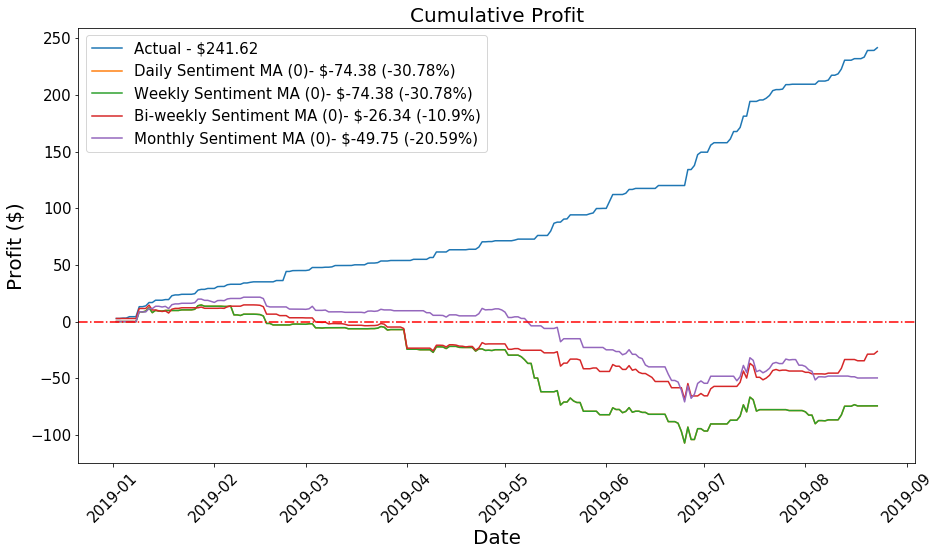

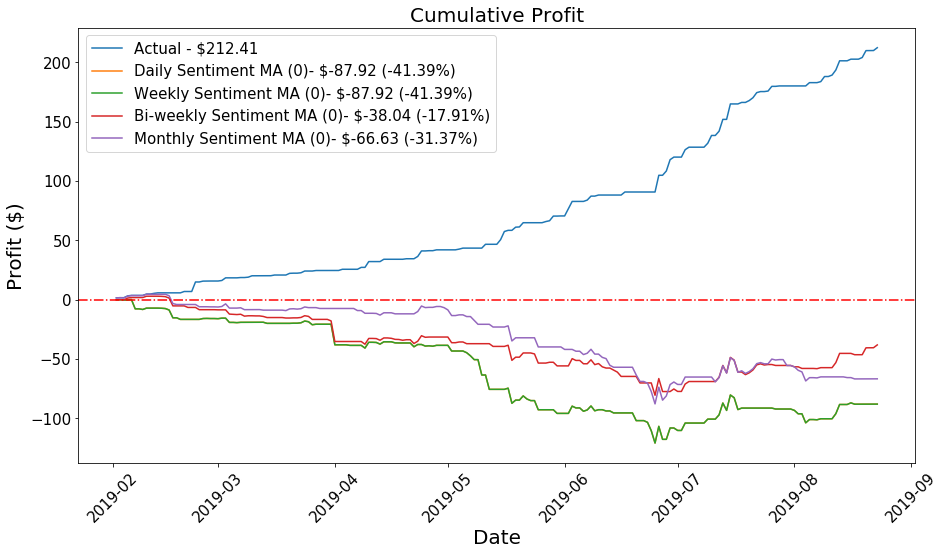

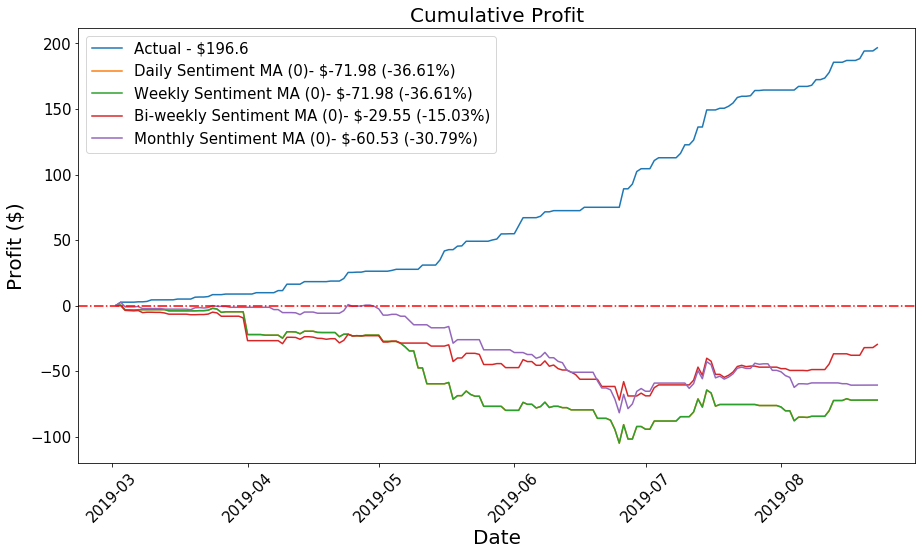

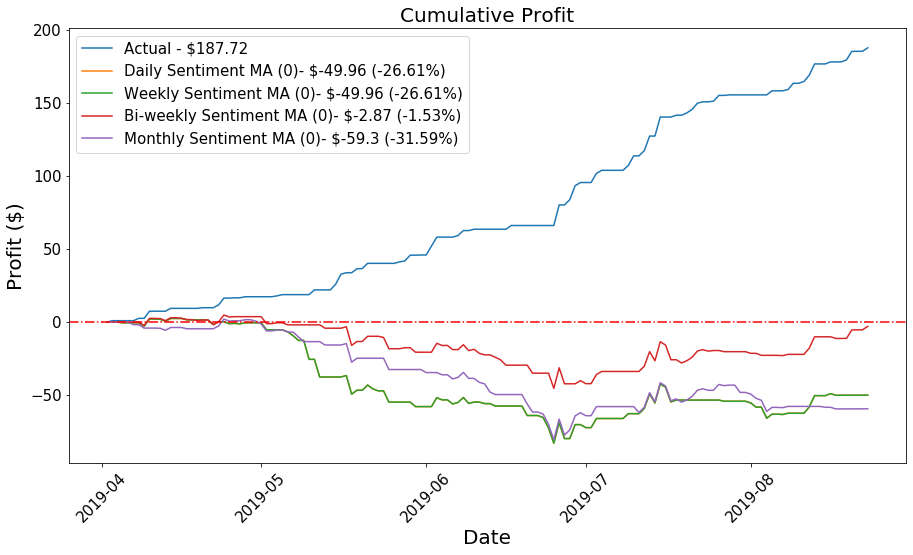

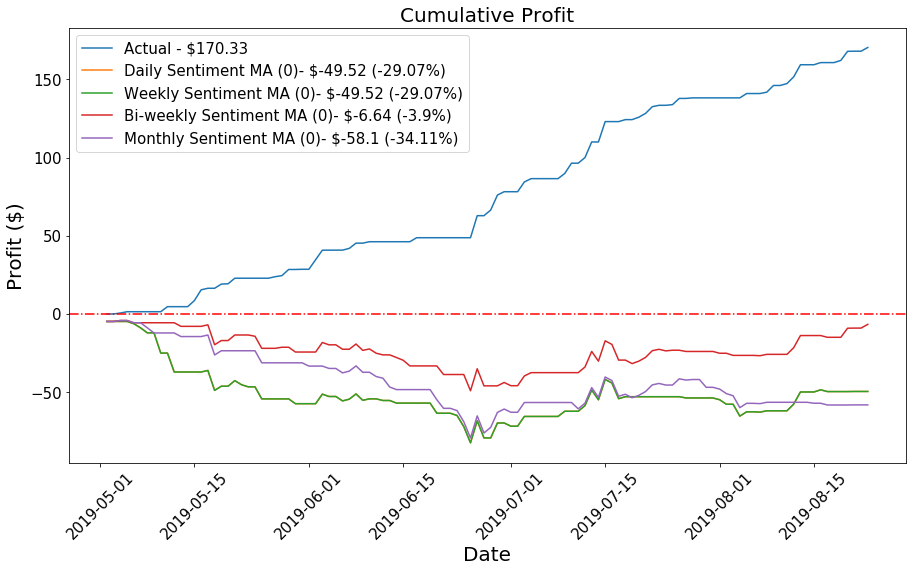

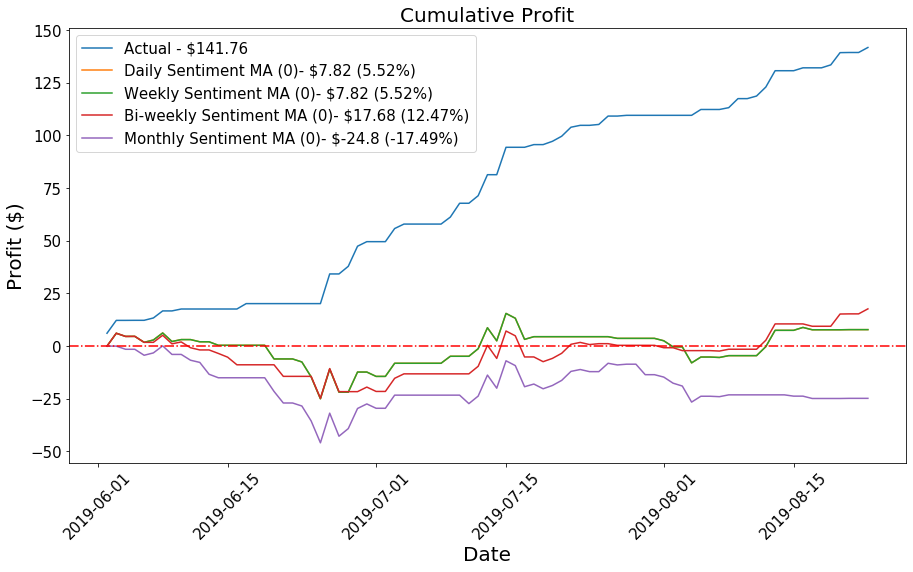

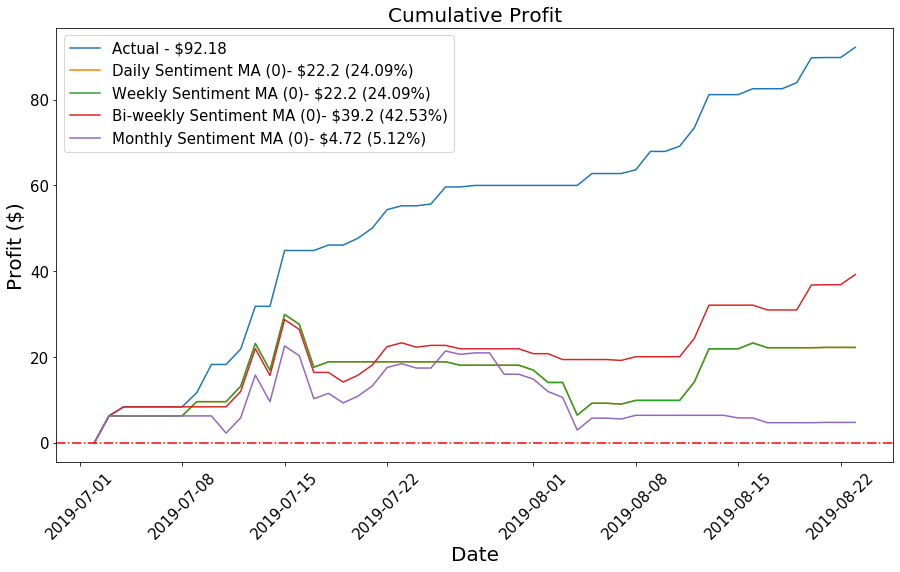

In [700]:
for i in range(1,8):
    # 2018.6 Market stabilized 
    min_date = date(2014,1,1)
    max_date = date(2019,i,1)
    model_profit_graph(df_daily,min_date,max_date,0,False,model_pred) #'dynamic' or 'simple'

#### Simple NN

##### Split Data & Apply StandardScaler

In [820]:
# 2018.6 Market stabilized 
min_date = date(2014,6,1)
max_date = date(2019,8,1)
max_max_date = max_date+timedelta(days=80)

mask_train = ((df_daily['date']>min_date) & (df_daily['date']<(max_date- timedelta(days=15))))
mask_test = ((df_daily['date'] > max_date)&(df_daily['date'] < max_max_date))

features = [#'final_sentiment',
#            'open',
#            'high',
#            'low',
#            'close',
#            'volume',
#            'market_cap',
            'percent_change_volume',
#            'percent_change_daily_open',
#            'percent_change_wkly_open',
#            'percent_change_monthly_open',
            'percent_change_daily_close',
            'percent_change_wkly_close',
            'daily_sentiment_change',
            'wkly_sentiment_change',
            '2wk_sentiment_change'
#             ,0
#             ,1
#             ,2
#             ,3
#             ,4
#             ,5
#             ,6
#             ,7
#             ,8
#             ,9
#             ,10
#             ,11
#             ,12
           ]
target = ['target_daily']

df_train = df_daily[mask_train].dropna().copy() 
df_test =  df_daily[mask_test].dropna().copy()

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]


# Split train into train & val for NN training. shuffle=False so that it doesn't look into the future
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1,shuffle=True)

# Perform Scaling on Train Data and Apply to Val and Test Set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Holdout set percentage : {} %".format(len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100))

Holdout set percentage : 2.171767028627838 %


##### Define and Train NN

In [827]:
# Model
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Input
from keras.optimizers import Adam

# Initialize Model
nn = Sequential()

# Input layer & hidden layer
nn.add(Dense(2, input_shape=(X_train.shape[1],), activation='relu'))
# nn.add(Dropout(0.2))
# nn.add(Dense(4,activation='relu'))
# nn.add(Dropout(0.2))

# Output layer
nn.add(Dense(1))
# Compile the architecture and view summary
optimizer = Adam(lr=0.01)
nn.compile(optimizer=optimizer, loss='mean_squared_error')
#nn.summary()

from keras.callbacks import ModelCheckpoint,EarlyStopping

# Early Stopping for the nn
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]

# Train the model
nn.fit(x=X_train,y=y_train.values, epochs=70,shuffle=True,
          validation_data=(X_val, y_val.values),callbacks=callbacks_list)# validation_split=0.2)#) #, callbacks=callbacks_list)
model_pred = nn.predict(X_test)

# # Save Trained Model
# with open('nn.pkl', 'wb') as picklefile:
#     pickle.dump(nn, picklefile)    


Train on 891 samples, validate on 100 samples
Epoch 1/70
891/891 [==============================] - 5s 5ms/step - loss: 0.5414 - val_loss: 0.0620
Epoch 2/70
891/891 [==============================] - 0s 145us/step - loss: 0.1856 - val_loss: 0.0142
Epoch 3/70
891/891 [==============================] - 0s 154us/step - loss: 0.0801 - val_loss: 0.0078
Epoch 4/70
891/891 [==============================] - 0s 157us/step - loss: 0.0370 - val_loss: 0.0036
Epoch 5/70
891/891 [==============================] - 0s 160us/step - loss: 0.0142 - val_loss: 0.0026
Epoch 6/70
891/891 [==============================] - 0s 159us/step - loss: 0.0056 - val_loss: 0.0020
Epoch 7/70
891/891 [==============================] - 0s 164us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 8/70
891/891 [==============================] - 0s 166us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 9/70
891/891 [==============================] - 0s 169us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/70
891/891 [=================

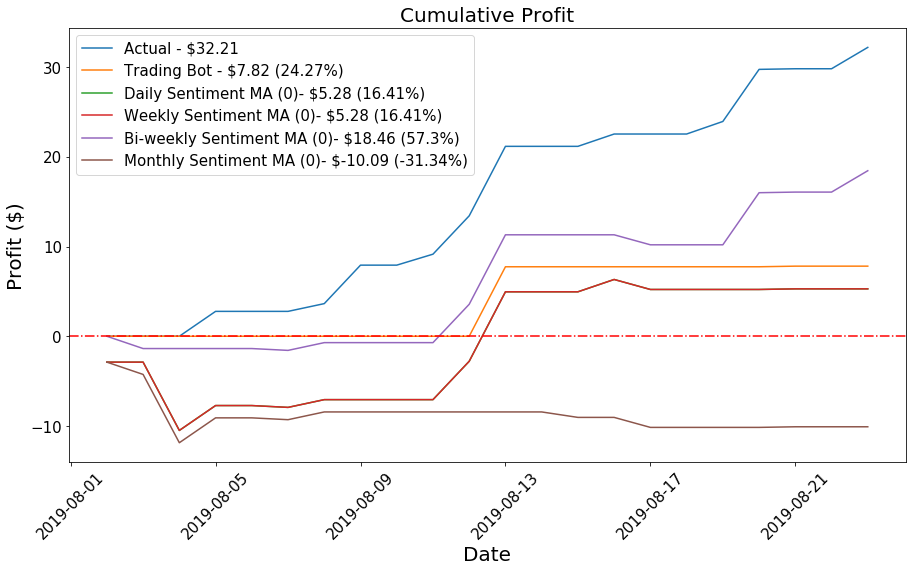

In [828]:
model_profit_graph(df_daily,min_date,max_date,date(2020,1,1),0,True,model_pred) #'dynamic' or 'simple'

In [835]:
date_ranges, best_cases,dailys,weeklys,biweeklys,monthlys,models = [],[],[],[],[],[],[]
for i in range((date.today()-date(2019,7,1)).days-1):
    # 2018.6 Market stabilized
    min_date = date(2014,6,1)
    max_date = date(2019,7,1)+timedelta(days=i)
    max_max_date = max_date+timedelta(days=2)

    mask_train = ((df_daily['date']>min_date) & (df_daily['date']<(max_date- timedelta(days=15))))
    mask_test = ((df_daily['date'] > max_date)&(df_daily['date'] < max_max_date))

    features = ['percent_change_volume',
                'percent_change_daily_close',
                'percent_change_wkly_close',
                'daily_sentiment_change',
                'wkly_sentiment_change',
                '2wk_sentiment_change']
    target = ['target_daily']

    df_train = df_daily[mask_train].dropna().copy() 
    df_test =  df_daily[mask_test].dropna().copy()

    X_train = df_train[features]
    y_train = df_train[target]

    X_test = df_test[features]
    y_test = df_test[target]


    # Split train into train & val for NN training. shuffle=False so that it doesn't look into the future
    from sklearn.model_selection import train_test_split
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1,shuffle=True)

    # Perform Scaling on Train Data and Apply to Val and Test Set
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    print("Holdout set percentage : {} %".format(len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100))
    # Model
    from keras.models import Sequential
    from keras.layers import Dense,Dropout,BatchNormalization,Input
    from keras.optimizers import Adam

    # Initialize Model
    nn = Sequential()

    # Input layer & hidden layer
    nn.add(Dense(2, input_shape=(X_train.shape[1],), activation='relu'))

    # Output layer
    nn.add(Dense(1))
    # Compile the architecture and view summary
    optimizer = Adam(lr=0.01)
    nn.compile(optimizer=optimizer, loss='mean_squared_error')

    from keras.callbacks import ModelCheckpoint,EarlyStopping

    # Early Stopping for the nn
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto',restore_best_weights=True)
    callbacks_list = [early_stopping]

    # Train the model
    nn.fit(x=X_train,y=y_train.values, epochs=70,shuffle=True,
              validation_data=(X_val, y_val.values),callbacks=callbacks_list)# validation_split=0.2)#) #, callbacks=callbacks_list)
    model_pred = nn.predict(X_test)

 
    date_range, best_case,daily,weekly,biweekly,monthly,model = model_profit_moving(df_daily,min_date,max_date,max_max_date,0,True,model_pred) #'dynamic' or 'simple'
    date_ranges.append(date_range)
    best_cases.append(best_case)
    dailys.append(daily)
    weeklys.append(weekly)
    biweeklys.append(biweekly)
    monthlys.append(monthly)
    models.append(model)
   

    

Holdout set percentage : 0.10405827263267431 %
Train on 864 samples, validate on 96 samples
Epoch 1/70
864/864 [==============================] - 6s 7ms/step - loss: 0.7452 - val_loss: 0.0919
Epoch 2/70
864/864 [==============================] - 0s 156us/step - loss: 0.3239 - val_loss: 0.0268
Epoch 3/70
864/864 [==============================] - 0s 165us/step - loss: 0.1889 - val_loss: 0.0098
Epoch 4/70
864/864 [==============================] - 0s 163us/step - loss: 0.1194 - val_loss: 0.0056
Epoch 5/70
864/864 [==============================] - 0s 164us/step - loss: 0.0838 - val_loss: 0.0052
Epoch 6/70
864/864 [==============================] - 0s 167us/step - loss: 0.0604 - val_loss: 0.0043
Epoch 7/70
864/864 [==============================] - 0s 158us/step - loss: 0.0406 - val_loss: 0.0039
Epoch 8/70
864/864 [==============================] - 0s 183us/step - loss: 0.0321 - val_loss: 0.0035
Epoch 9/70
864/864 [==============================] - 0s 224us/step - loss: 0.0188 - val_loss:

866/866 [==============================] - 0s 183us/step - loss: 0.0064 - val_loss: 0.0017
Epoch 18/70
866/866 [==============================] - 0s 152us/step - loss: 0.0056 - val_loss: 0.0017
Epoch 19/70
866/866 [==============================] - 0s 152us/step - loss: 0.0049 - val_loss: 0.0017
Epoch 20/70
866/866 [==============================] - 0s 149us/step - loss: 0.0044 - val_loss: 0.0017
Epoch 21/70
866/866 [==============================] - 0s 160us/step - loss: 0.0040 - val_loss: 0.0016
Epoch 22/70
866/866 [==============================] - 0s 157us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 23/70
866/866 [==============================] - 0s 162us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 24/70
866/866 [==============================] - 0s 155us/step - loss: 0.0030 - val_loss: 0.0016
Holdout set percentage : 0.10362694300518134 %
Train on 867 samples, validate on 97 samples
Epoch 1/70
867/867 [==============================] - 6s 7ms/step - loss: 2.5806 - val_loss: 0.8

868/868 [==============================] - 0s 170us/step - loss: 0.0139 - val_loss: 0.0015
Epoch 12/70
868/868 [==============================] - 0s 161us/step - loss: 0.0107 - val_loss: 0.0015
Epoch 13/70
868/868 [==============================] - 0s 162us/step - loss: 0.0084 - val_loss: 0.0014
Epoch 14/70
868/868 [==============================] - 0s 159us/step - loss: 0.0069 - val_loss: 0.0014
Epoch 15/70
868/868 [==============================] - 0s 167us/step - loss: 0.0057 - val_loss: 0.0014
Epoch 16/70
868/868 [==============================] - 0s 160us/step - loss: 0.0048 - val_loss: 0.0014
Epoch 17/70
868/868 [==============================] - 0s 162us/step - loss: 0.0042 - val_loss: 0.0014
Holdout set percentage : 0.1034126163391934 %
Train on 869 samples, validate on 97 samples
Epoch 1/70
869/869 [==============================] - 6s 6ms/step - loss: 1.3973 - val_loss: 0.2029
Epoch 2/70
869/869 [==============================] - 0s 147us/step - loss: 0.5599 - val_loss: 0.111

870/870 [==============================] - 0s 163us/step - loss: 0.0519 - val_loss: 0.0044
Holdout set percentage : 0.10319917440660474 %
Train on 871 samples, validate on 97 samples
Epoch 1/70
871/871 [==============================] - 6s 7ms/step - loss: 0.1946 - val_loss: 4.2231
Epoch 2/70
871/871 [==============================] - 0s 148us/step - loss: 0.0643 - val_loss: 2.3378
Epoch 3/70
871/871 [==============================] - 0s 160us/step - loss: 0.0372 - val_loss: 1.4436
Epoch 4/70
871/871 [==============================] - 0s 164us/step - loss: 0.0206 - val_loss: 0.9865
Epoch 5/70
871/871 [==============================] - 0s 163us/step - loss: 0.0135 - val_loss: 0.7648
Epoch 6/70
871/871 [==============================] - 0s 166us/step - loss: 0.0100 - val_loss: 0.5598
Epoch 7/70
871/871 [==============================] - 0s 163us/step - loss: 0.0077 - val_loss: 0.4264
Epoch 8/70
871/871 [==============================] - 0s 162us/step - loss: 0.0060 - val_loss: 0.3550
Epo

872/872 [==============================] - 0s 165us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 18/70
872/872 [==============================] - 0s 168us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 19/70
872/872 [==============================] - 0s 160us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 20/70
872/872 [==============================] - 0s 168us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 21/70
872/872 [==============================] - 0s 165us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 22/70
872/872 [==============================] - 0s 163us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 23/70
872/872 [==============================] - 0s 240us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 24/70
872/872 [==============================] - 0s 186us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 25/70
872/872 [==============================] - 0s 176us/step - loss: 0.0018 - val_loss: 0.0025
Holdout set percentage : 0.10298661174047373 %
Train on 873 samples, validate on 97 s

Holdout set percentage : 0.102880658436214 %
Train on 873 samples, validate on 98 samples
Epoch 1/70
873/873 [==============================] - 6s 6ms/step - loss: 0.5267 - val_loss: 22.1540
Epoch 2/70
873/873 [==============================] - 0s 162us/step - loss: 0.2569 - val_loss: 13.6107
Epoch 3/70
873/873 [==============================] - 0s 163us/step - loss: 0.1604 - val_loss: 9.2559
Epoch 4/70
873/873 [==============================] - 0s 171us/step - loss: 0.1056 - val_loss: 6.9381
Epoch 5/70
873/873 [==============================] - 0s 167us/step - loss: 0.0706 - val_loss: 5.3349
Epoch 6/70
873/873 [==============================] - 0s 166us/step - loss: 0.0533 - val_loss: 3.8923
Epoch 7/70
873/873 [==============================] - 0s 166us/step - loss: 0.0373 - val_loss: 3.1665
Epoch 8/70
873/873 [==============================] - 0s 165us/step - loss: 0.0287 - val_loss: 2.5247
Epoch 9/70
873/873 [==============================] - 0s 168us/step - loss: 0.0228 - val_loss:

Epoch 9/70
874/874 [==============================] - 0s 164us/step - loss: 0.0595 - val_loss: 0.0018
Epoch 10/70
874/874 [==============================] - 0s 168us/step - loss: 0.0498 - val_loss: 0.0014
Epoch 11/70
874/874 [==============================] - 0s 165us/step - loss: 0.0423 - val_loss: 0.0011
Epoch 12/70
874/874 [==============================] - 0s 174us/step - loss: 0.0348 - val_loss: 0.0011
Epoch 13/70
874/874 [==============================] - 0s 170us/step - loss: 0.0245 - val_loss: 0.0016
Epoch 14/70
874/874 [==============================] - 0s 170us/step - loss: 0.0200 - val_loss: 0.0013
Epoch 15/70
874/874 [==============================] - 0s 179us/step - loss: 0.0175 - val_loss: 0.0015
Holdout set percentage : 0.10266940451745381 %
Train on 875 samples, validate on 98 samples
Epoch 1/70
875/875 [==============================] - 6s 7ms/step - loss: 1.4731 - val_loss: 23.0260
Epoch 2/70
875/875 [==============================] - 0s 157us/step - loss: 0.6401 - va

878/878 [==============================] - 0s 165us/step - loss: 0.0040 - val_loss: 0.0031
Epoch 3/70
878/878 [==============================] - 0s 167us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 4/70
878/878 [==============================] - 0s 172us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 5/70
878/878 [==============================] - 0s 176us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 6/70
878/878 [==============================] - 0s 177us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 7/70
878/878 [==============================] - 0s 171us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/70
878/878 [==============================] - 0s 180us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 9/70
878/878 [==============================] - 0s 169us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 10/70
878/878 [==============================] - 0s 173us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 11/70
878/878 [==============================] - 0s 173us/step - loss: 0.0019 - val_lo

881/881 [==============================] - 0s 169us/step - loss: 0.0038 - val_loss: 0.0028
Epoch 16/70
881/881 [==============================] - 0s 175us/step - loss: 0.0035 - val_loss: 0.0028
Epoch 17/70
881/881 [==============================] - 0s 176us/step - loss: 0.0032 - val_loss: 0.0028
Epoch 18/70
881/881 [==============================] - 0s 180us/step - loss: 0.0030 - val_loss: 0.0026
Epoch 19/70
881/881 [==============================] - 0s 172us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 20/70
881/881 [==============================] - 0s 178us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 21/70
881/881 [==============================] - 0s 170us/step - loss: 0.0029 - val_loss: 0.0024
Epoch 22/70
881/881 [==============================] - 0s 183us/step - loss: 0.0032 - val_loss: 0.0025
Epoch 23/70
881/881 [==============================] - 0s 169us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 24/70
881/881 [==============================] - 0s 165us/step - loss: 0.0028 -

884/884 [==============================] - 0s 179us/step - loss: 0.0022 - val_loss: 0.0078
Epoch 13/70
884/884 [==============================] - 0s 181us/step - loss: 0.0021 - val_loss: 0.0074
Epoch 14/70
884/884 [==============================] - 0s 176us/step - loss: 0.0021 - val_loss: 0.0068
Epoch 15/70
884/884 [==============================] - 0s 178us/step - loss: 0.0021 - val_loss: 0.0063
Epoch 16/70
884/884 [==============================] - 0s 173us/step - loss: 0.0020 - val_loss: 0.0060
Epoch 17/70
884/884 [==============================] - 0s 178us/step - loss: 0.0020 - val_loss: 0.0057
Epoch 18/70
884/884 [==============================] - 0s 176us/step - loss: 0.0020 - val_loss: 0.0055
Epoch 19/70
884/884 [==============================] - 0s 176us/step - loss: 0.0020 - val_loss: 0.0053
Epoch 20/70
884/884 [==============================] - 0s 174us/step - loss: 0.0020 - val_loss: 0.0051
Epoch 21/70
884/884 [==============================] - 0s 189us/step - loss: 0.0020 -

886/886 [==============================] - 0s 188us/step - loss: 0.0027 - val_loss: 0.0042
Epoch 17/70
886/886 [==============================] - 0s 168us/step - loss: 0.0025 - val_loss: 0.0039
Epoch 18/70
886/886 [==============================] - 0s 163us/step - loss: 0.0024 - val_loss: 0.0037
Epoch 19/70
886/886 [==============================] - 0s 165us/step - loss: 0.0023 - val_loss: 0.0036
Epoch 20/70
886/886 [==============================] - 0s 172us/step - loss: 0.0022 - val_loss: 0.0034
Epoch 21/70
886/886 [==============================] - 0s 180us/step - loss: 0.0022 - val_loss: 0.0033
Epoch 22/70
886/886 [==============================] - 0s 174us/step - loss: 0.0021 - val_loss: 0.0032
Epoch 23/70
886/886 [==============================] - 0s 175us/step - loss: 0.0021 - val_loss: 0.0031
Epoch 24/70
886/886 [==============================] - 0s 177us/step - loss: 0.0020 - val_loss: 0.0030
Epoch 25/70
886/886 [==============================] - 0s 169us/step - loss: 0.0020 -

889/889 [==============================] - 0s 183us/step - loss: 0.0074 - val_loss: 0.0055
Epoch 13/70
889/889 [==============================] - 0s 179us/step - loss: 0.0065 - val_loss: 0.0048
Epoch 14/70
889/889 [==============================] - 0s 176us/step - loss: 0.0057 - val_loss: 0.0043
Epoch 15/70
889/889 [==============================] - 0s 181us/step - loss: 0.0050 - val_loss: 0.0038
Epoch 16/70
889/889 [==============================] - 0s 181us/step - loss: 0.0044 - val_loss: 0.0034
Epoch 17/70
889/889 [==============================] - 0s 181us/step - loss: 0.0040 - val_loss: 0.0031
Epoch 18/70
889/889 [==============================] - 0s 189us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 19/70
889/889 [==============================] - 0s 177us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 20/70
889/889 [==============================] - 0s 178us/step - loss: 0.0031 - val_loss: 0.0024
Epoch 21/70
889/889 [==============================] - 0s 179us/step - loss: 0.0029 -

891/891 [==============================] - 0s 198us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 28/70
891/891 [==============================] - 0s 189us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 29/70
891/891 [==============================] - 0s 187us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 30/70
891/891 [==============================] - 0s 191us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 31/70
891/891 [==============================] - 0s 188us/step - loss: 0.0020 - val_loss: 0.0018
Holdout set percentage : 0.10080645161290322 %
Train on 891 samples, validate on 100 samples
Epoch 1/70
891/891 [==============================] - 6s 7ms/step - loss: 1.0780 - val_loss: 0.3358
Epoch 2/70
891/891 [==============================] - 0s 177us/step - loss: 0.3519 - val_loss: 0.0890
Epoch 3/70
891/891 [==============================] - 0s 183us/step - loss: 0.1504 - val_loss: 0.0367
Epoch 4/70
891/891 [==============================] - 0s 190us/step - loss: 0.0870 - val_loss: 0.018

892/892 [==============================] - 0s 188us/step - loss: 0.0039 - val_loss: 0.0045
Epoch 38/70
892/892 [==============================] - 0s 184us/step - loss: 0.0037 - val_loss: 0.0044
Epoch 39/70
892/892 [==============================] - 0s 187us/step - loss: 0.0036 - val_loss: 0.0043
Epoch 40/70
892/892 [==============================] - 0s 185us/step - loss: 0.0034 - val_loss: 0.0043
Epoch 41/70
892/892 [==============================] - 0s 185us/step - loss: 0.0033 - val_loss: 0.0043
Epoch 42/70
892/892 [==============================] - 0s 184us/step - loss: 0.0032 - val_loss: 0.0042
Epoch 43/70
892/892 [==============================] - 0s 264us/step - loss: 0.0031 - val_loss: 0.0041
Epoch 44/70
892/892 [==============================] - 0s 195us/step - loss: 0.0030 - val_loss: 0.0041
Epoch 45/70
892/892 [==============================] - 0s 195us/step - loss: 0.0029 - val_loss: 0.0040
Epoch 46/70
892/892 [==============================] - 0s 185us/step - loss: 0.0028 -

893/893 [==============================] - 0s 189us/step - loss: 0.0023 - val_loss: 4.5387
Epoch 46/70
893/893 [==============================] - 0s 192us/step - loss: 0.0023 - val_loss: 4.4841
Epoch 47/70
893/893 [==============================] - 0s 183us/step - loss: 0.0022 - val_loss: 4.4050
Epoch 48/70
893/893 [==============================] - 0s 188us/step - loss: 0.0022 - val_loss: 4.2708
Epoch 49/70
893/893 [==============================] - 0s 186us/step - loss: 0.0021 - val_loss: 4.1920
Epoch 50/70
893/893 [==============================] - 0s 208us/step - loss: 0.0021 - val_loss: 4.1541
Epoch 51/70
893/893 [==============================] - 0s 192us/step - loss: 0.0021 - val_loss: 4.0784
Epoch 52/70
893/893 [==============================] - 0s 190us/step - loss: 0.0020 - val_loss: 3.9584
Epoch 53/70
893/893 [==============================] - 0s 177us/step - loss: 0.0020 - val_loss: 3.9108
Epoch 54/70
893/893 [==============================] - 0s 188us/step - loss: 0.0020 -

897/897 [==============================] - 0s 185us/step - loss: 0.0285 - val_loss: 0.0064
Epoch 3/70
897/897 [==============================] - 0s 190us/step - loss: 0.0129 - val_loss: 0.0033
Epoch 4/70
897/897 [==============================] - 0s 197us/step - loss: 0.0071 - val_loss: 0.0026
Epoch 5/70
897/897 [==============================] - 0s 197us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 6/70
897/897 [==============================] - 0s 188us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 7/70
897/897 [==============================] - 0s 201us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 8/70
897/897 [==============================] - 0s 191us/step - loss: 0.0026 - val_loss: 0.0024
Holdout set percentage : 0.10010010010010009 %
Train on 898 samples, validate on 100 samples
Epoch 1/70
898/898 [==============================] - 7s 8ms/step - loss: 0.2781 - val_loss: 0.0787
Epoch 2/70
898/898 [==============================] - 0s 192us/step - loss: 0.1009 - val_loss: 0.0382
Ep

900/900 [==============================] - 0s 217us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 21/70
900/900 [==============================] - 0s 219us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 22/70
900/900 [==============================] - 0s 198us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 23/70
900/900 [==============================] - 0s 224us/step - loss: 0.0019 - val_loss: 0.0022
Holdout set percentage : 0.09980039920159679 %
Train on 900 samples, validate on 101 samples
Epoch 1/70
900/900 [==============================] - 7s 8ms/step - loss: 0.2986 - val_loss: 0.1136
Epoch 2/70
900/900 [==============================] - 0s 184us/step - loss: 0.0613 - val_loss: 0.0308
Epoch 3/70
900/900 [==============================] - 0s 198us/step - loss: 0.0212 - val_loss: 0.0131
Epoch 4/70
900/900 [==============================] - 0s 203us/step - loss: 0.0096 - val_loss: 0.0072
Epoch 5/70
900/900 [==============================] - 0s 196us/step - loss: 0.0057 - val_loss: 0.0050

901/901 [==============================] - 0s 347us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 52/70
901/901 [==============================] - 0s 326us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 53/70
901/901 [==============================] - 0s 328us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 54/70
901/901 [==============================] - 0s 222us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 55/70
901/901 [==============================] - 0s 340us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 56/70
901/901 [==============================] - 0s 329us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 57/70
901/901 [==============================] - 0s 324us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 58/70
901/901 [==============================] - 0s 338us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 59/70
901/901 [==============================] - 0s 319us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 60/70
901/901 [==============================] - 0s 339us/step - loss: 0.0020 -

904/904 [==============================] - 0s 216us/step - loss: 0.0373 - val_loss: 0.0091
Epoch 6/70
904/904 [==============================] - 0s 211us/step - loss: 0.0256 - val_loss: 0.0071
Epoch 7/70
904/904 [==============================] - 0s 212us/step - loss: 0.0190 - val_loss: 0.0054
Epoch 8/70
904/904 [==============================] - 0s 202us/step - loss: 0.0141 - val_loss: 0.0052
Epoch 9/70
904/904 [==============================] - 0s 195us/step - loss: 0.0115 - val_loss: 0.0042
Epoch 10/70
904/904 [==============================] - 0s 199us/step - loss: 0.0090 - val_loss: 0.0033
Epoch 11/70
904/904 [==============================] - 0s 196us/step - loss: 0.0076 - val_loss: 0.0030
Epoch 12/70
904/904 [==============================] - 0s 202us/step - loss: 0.0063 - val_loss: 0.0028
Epoch 13/70
904/904 [==============================] - 0s 210us/step - loss: 0.0054 - val_loss: 0.0025
Epoch 14/70
904/904 [==============================] - 0s 209us/step - loss: 0.0046 - val

907/907 [==============================] - 0s 314us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 13/70
907/907 [==============================] - 0s 295us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 14/70
907/907 [==============================] - 0s 288us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 15/70
907/907 [==============================] - 0s 346us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 16/70
907/907 [==============================] - 0s 313us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 17/70
907/907 [==============================] - 0s 338us/step - loss: 0.0020 - val_loss: 0.0018
Holdout set percentage : 0.09900990099009901 %
Train on 908 samples, validate on 101 samples
Epoch 1/70
908/908 [==============================] - 7s 8ms/step - loss: 0.9922 - val_loss: 0.1038
Epoch 2/70
908/908 [==============================] - 0s 216us/step - loss: 0.2736 - val_loss: 0.0509
Epoch 3/70
908/908 [==============================] - 0s 226us/step - loss: 0.1386 - val_loss: 0.02

KeyboardInterrupt: 

In [839]:
date_ranges

[(datetime.date(2019, 7, 1), datetime.date(2019, 7, 3)),
 (datetime.date(2019, 7, 2), datetime.date(2019, 7, 4)),
 (datetime.date(2019, 7, 3), datetime.date(2019, 7, 5)),
 (datetime.date(2019, 7, 4), datetime.date(2019, 7, 6)),
 (datetime.date(2019, 7, 5), datetime.date(2019, 7, 7)),
 (datetime.date(2019, 7, 6), datetime.date(2019, 7, 8)),
 (datetime.date(2019, 7, 7), datetime.date(2019, 7, 9)),
 (datetime.date(2019, 7, 8), datetime.date(2019, 7, 10)),
 (datetime.date(2019, 7, 9), datetime.date(2019, 7, 11)),
 (datetime.date(2019, 7, 10), datetime.date(2019, 7, 12)),
 (datetime.date(2019, 7, 11), datetime.date(2019, 7, 13)),
 (datetime.date(2019, 7, 12), datetime.date(2019, 7, 14)),
 (datetime.date(2019, 7, 13), datetime.date(2019, 7, 15)),
 (datetime.date(2019, 7, 14), datetime.date(2019, 7, 16)),
 (datetime.date(2019, 7, 15), datetime.date(2019, 7, 17)),
 (datetime.date(2019, 7, 16), datetime.date(2019, 7, 18)),
 (datetime.date(2019, 7, 17), datetime.date(2019, 7, 19)),
 (datetime.da

In [836]:
#2019 7~ dynamic threshold
print('Best Case ${}'.format(np.sum(best_cases)))
print('dailys ${}'.format(np.sum(dailys)))
print('weeklys ${}'.format(np.sum(weeklys)))
print('biweeklys ${}'.format(np.sum(biweeklys)))
print('monthlys ${}'.format(np.sum(monthlys)))

Best Case $89.80000000000001
dailys $22.209999999999997
weeklys $22.209999999999997
biweeklys $36.86
monthlys $4.729999999999997


In [ ]:
# 2018.6 Market stabilized 
min_date = date(2014,6,1)
max_date = date(2019,7,1)
model_profit_graph(df_daily,min_date,max_date,date(2020,1,1),0,False,model_pred) #'dynamic' or 'simple'

#### LSTM

In [77]:
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, BatchNormalization, Activation, Bidirectional
from keras.models import Sequential
import tensorflow as tf

In [78]:
min_date = date(2017,6,1)
val_date = date(2019,4,1)
max_date = date(2019,7,1)


mask_train = ((df_daily['date']>min_date) & (df_daily['date']<val_date))
mask_val = ((df_daily['date']>val_date) & (df_daily['date']<max_date))
mask_test = (df_daily['date'] > max_date) 

features = ['percent_change_volume'
            ,'percent_change_daily_open'
#            ,'percent_change_wkly_open'
            #,'percent_change_monthly_open'
            ,'daily_sentiment_change'
#            ,'wkly_sentiment_change'
            #,'2wk_sentiment_change'
            #,'4wk_sentiment_change'
            ,'open'
            ,'volume'
            ,0
            ,1
            ,2
            ,3
            ,4
            ,5
            ,6
            ,7
            ,8
            ,9
            ,10
            ,11
            ,12
           ]
target = ['target_daily']



df_train = df_daily[mask_train].dropna().copy()
df_val = df_daily[mask_val].dropna().copy()
df_test =  df_daily[mask_test].dropna().copy()

# Perform Scaling on Train Data and Apply to Val and Test Set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features]).T
X_val = scaler.transform(df_val[features]).T
X_test = scaler.transform(df_test[features]).T

#X_train = df_train[features].T
y_train = np.array(df_train[target])
y_train = y_train.reshape(-1,y_train.shape[1])

#X_val = df_val[features].T
y_val = np.array(df_val[target])
y_val = y_val.reshape(-1,y_val.shape[1])

#X_test = df_test[features].T
y_test = np.array(df_test[target])
y_test = y_test.reshape(-1,y_test.shape[1])

# # Split train into train & val for NN training. shuffle=False so that it doesn't look into the future
# from sklearn.model_selection import train_test_split
# X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.15,shuffle=False)


print("Holdout set percentage : {} %".format(len(df_test)/(len(df_train)+len(df_val)+len(df_test))*100))

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  import sys
/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the fu

KeyError: '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] not in index'

In [1115]:
X_train = X_train.reshape(1,X_train.shape[1],X_train.shape[0])
X_val = X_val.reshape(1,X_val.shape[1],X_val.shape[0])
X_test = X_test.reshape(1,X_test.shape[1],X_test.shape[0])

In [1116]:
model = Sequential()

# Define LSTM Model
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')
# callbacks = [EarlyStopping(monitor='val_mean_squared_error', patience=20),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_mean_squared_error', save_best_only=True,mode='max')]
# model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=200, batch_size=128, verbose=1,callbacks=callbacks)
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               75264     
_________________________________________________________________
dropout_134 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_304 (Dense)            (None, 16)                2064      
_________________________________________________________________
dropout_135 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_305 (Dense)            (None, 1)                 17        
Total params: 77,345
Trainable params: 77,345
Non-trainable params: 0
_________________________________________________________________


ValueError: Input arrays should have the same number of samples as target arrays. Found 1 input samples and 668 target samples.

In [1061]:
y_train.shape



(1, 668)